In [191]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from linear_genetic_programming.lgp_classifier import LGPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline


In [192]:
sns.set()
np.random.seed(0)

In [193]:
# Dr. Steffany data New Preprocessing
# 1: control, 0: case
# path2pickle = '../dataset/lgp702SteffanyNew.pkl'
# path2pickle = '../dataset/DLB_sub_lgp.pkl'
# df = pd.read_csv('../dataset/Discovery_Cohort2020_08_25_forTing_imputed_fifth_min.csv')
df = pd.read_csv('../dataset/sub_DLB_metabolomics.csv')
names = df.columns[5:]
y = df['Diagnosis'].to_numpy()
y = np.where(y == 'DLB', 0, y)
y = np.where(y == 'CTRL', 1, y)
y = y.tolist()
X = df.iloc[:, 5:].to_numpy()
scaler=MinMaxScaler((-1,1))
X = scaler.fit_transform(X)

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Random Forest Baseline

In [195]:
# !!!!!!!!!!!!!!!!!!-------------- random forest ------------------!!!!!!!!!!!!!!!!!!!!!!!!!!
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=0)
model_rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [196]:
y_predict = model_rf.predict(X_test)

In [197]:
from sklearn.metrics import classification_report

In [198]:
print(classification_report(y_test, y_predict))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.94      0.97        16

    accuracy                           0.96        25
   macro avg       0.95      0.97      0.96        25
weighted avg       0.96      0.96      0.96        25



In [199]:
metrics.f1_score(y_test, y_predict, pos_label=0)



0.9473684210526316

In [200]:
y_prob = model_rf.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob, pos_label=0)
metrics.auc(fpr, tpr)


0.9895833333333333

In [201]:
cv_results  = cross_validate(model_rf, X, y, cv=5, return_estimator=True, scoring='f1')


In [202]:
cv_results['estimator']

(RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0),
 RandomForestClassifier(random_state=0))

In [203]:
cv_results['test_score']

array([0.86666667, 0.85714286, 0.82758621, 0.90909091, 0.875     ])

In [204]:
# ---- averaging --------
rf_list = []
for estimator in cv_results['estimator']:
    rf_list.append( pd.Series(model_rf.feature_importances_, index=names).sort_values(ascending=False))

In [205]:
pd_group = pd.concat(rf_list)
group_info = pd_group.groupby(pd_group.index)
df_means = group_info.mean().sort_values(ascending=False)

In [206]:
df_means = df_means.head(20)

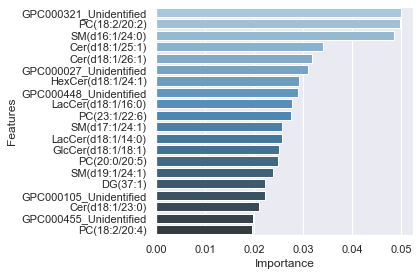

In [207]:
ax = sns.barplot(x=df_means[:20], y=df_means.index[:20], palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_rf.tif', dpi=300)
plt.show()

In [208]:
feature_scores_rf = pd.Series(model_rf.feature_importances_, index=names).sort_values(ascending=False)

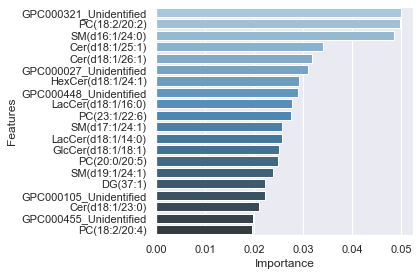

In [209]:
ax = sns.barplot(x=df_means.values, y=df_means.index,  palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_rf_avg.tif', dpi=300)
plt.show()

In [210]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

# ax = plt.gca()
# for i in models_unfiltered:
# 	plot_roc_curve(i, X_test, y_test, ax=ax)

In [211]:
# for estimator in cv_results['estimator']:
#     plot_roc_curve(estimator, X_test, y_test)
# plt.savefig('ROC_rf.tif', dpi=300)

In [212]:
all_accuracies = cross_val_score(estimator=model_rf, X=X_train, y=y_train, cv=5, n_jobs=-1)
print(all_accuracies.mean())

0.8189473684210526


## SVM baseline

In [213]:
# !!!!!!!!!!!!!!!!!!!!!!!!!----------- SVM ------------!!!!!!!!!!!!!!!!!!!!!
from sklearn import svm
clf = svm.SVC(kernel='linear', random_state=0)
clf.fit(X_train,y_train)


SVC(kernel='linear', random_state=0)

In [214]:
y_predict = model_rf.predict(X_test)

In [215]:
from sklearn.metrics import classification_report

In [216]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.94      0.97        16

    accuracy                           0.96        25
   macro avg       0.95      0.97      0.96        25
weighted avg       0.96      0.96      0.96        25



In [217]:
cv_results  = cross_validate(clf, X, y, cv=5, return_estimator=True, scoring='f1')

In [218]:
cv_results['estimator']

(SVC(kernel='linear', random_state=0),
 SVC(kernel='linear', random_state=0),
 SVC(kernel='linear', random_state=0),
 SVC(kernel='linear', random_state=0),
 SVC(kernel='linear', random_state=0))

In [219]:
cv_results['test_score']

array([0.75862069, 0.88888889, 0.82758621, 0.85714286, 0.77419355])

In [220]:
# ---- averaging --------
svm_list = []
for estimator in cv_results['estimator']:
    svm_list.append(pd.Series(abs(estimator.coef_[0]), index=names).nlargest(20))

In [221]:
pd_group = pd.concat(svm_list)
group_info = pd_group.groupby(pd_group.index)
df_means = group_info.mean().sort_values(ascending=False)

In [222]:
# df_means = df_means.to_frame()
df_means = df_means.head(20)

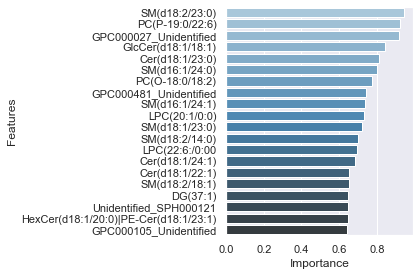

In [223]:
ax = sns.barplot(x=df_means.values, y=df_means.index, palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_svm_avg.tif', dpi=400)
plt.show()
# ---- end averaging --------

In [224]:
y_predict = clf.predict(X_test)
accuracy_score(y_predict, y_test)

0.88

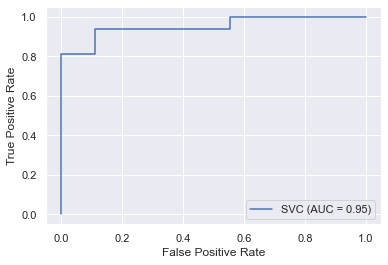

In [225]:
plot_roc_curve(clf, X_test, y_test)

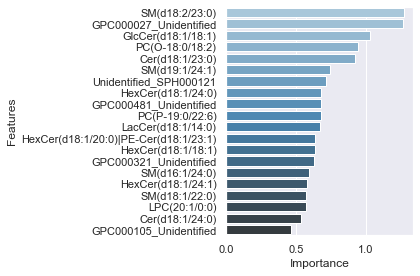

In [226]:
feature_scores_svm = pd.Series(abs(clf.coef_[0]), index=names).nlargest(20)
ax = sns.barplot(x=feature_scores_svm.values, y=feature_scores_svm.index, palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_svm.tif', dpi=400)
plt.show()

In [227]:
# some random data frames
df1 = pd.DataFrame(dict(x=np.random.randn(100), y=np.random.randint(0, 5, 100)))
df2 = pd.DataFrame(dict(x=np.random.randn(100), y=np.random.randint(0, 5, 100)))

# concatenate them
df_concat = pd.concat((df1, df2))

In [228]:
# for estimator in cv_results['estimator']:
#     plot_roc_curve(estimator, X_test, y_test)